In [1]:
with open('./function/requirements_import.py') as f:
    exec(f.read())
    
from datetime import datetime
import scipy.stats as stats
from scipy.stats import spearmanr

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.outliers_influence import variance_inflation_factor

from catboost import CatBoostClassifier

In [2]:
file_path = './data/rainfall_train_v3.csv'
rainfall = pd.read_csv(file_path)

In [3]:
rainfall

,fc_year,fc_month,fc_day,fc_hour,stn4contest,dh,ef_month,ef_day,ef_hour,v01,...,rng_v03,rng_v04,rng_v05,rng_v06,rng_v07,rng_v08,rng_v09,pred,pred_YN,timestamp_log
0,A,5,1,9,1,3,5,1,12,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,21.205612
1,A,5,1,9,1,6,5,1,15,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,21.205619
2,A,5,1,9,1,9,5,1,18,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,21.205625
3,A,5,1,9,1,12,5,1,21,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,21.205632
4,A,5,1,9,1,15,5,2,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,21.205639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452715,C,9,30,21,20,228,10,10,9,9.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2,0,21.252086
1452716,C,9,30,21,20,231,10,10,12,13.0,...,2.0,2.0,1.0,0.0,0.0,0.0,0.0,2,1,21.252092
1452717,C,9,30,21,20,234,10,10,15,13.0,...,2.0,2.0,1.0,0.0,0.0,0.0,0.0,2,0,21.252098
1452718,C,9,30,21,20,237,10,10,18,8.0,...,2.0,0.0,2.0,0.0,0.0,0.0,0.0,5,1,21.252105


# 변수생성

In [4]:
temp = rainfall.loc[:, ['fc_year', 'fc_month', 'fc_day', 'fc_hour', 'stn4contest'] + [f'v0{i}' for i in range(1,10)]]

temp[['fc_year']] = temp[['fc_year']].replace({'A': 2021, 'B': 2022, 'C': 2023}) #임시값
temp['datetime'] = temp.apply(lambda row: datetime(int(row['fc_year']), int(row['fc_month']), int(row['fc_day']), int(row['fc_hour'])), axis=1)

temp['Weekday'] = pd.to_datetime(temp['datetime']).dt.weekday
temp['IsWeekend'] = temp['Weekday'] >= 5

col = [f'v0{i}' for i in range(1,10)]
col1 = ['fc_year', 'fc_month', 'fc_day', 'fc_hour', 'stn4contest', 'Weekday', 'IsWeekend']
col2 = ['y', 'm', 'd', 'h', 'aws', 'w', 'isw']

for a,b in zip(col1, col2):
    for val in col:
        dic = temp.groupby(a)[val].mean().to_dict()
        temp[f'{b}_{val}'] = temp[a].map(dic)
        
for val in col:
    temp[f'diff_{val}'] = rainfall[val].diff()
    result = seasonal_decompose(rainfall[val], model='additive', period=80)
    temp[f't_{val}'] = result.trend
    temp[f's_{val}'] = result.seasonal
    temp[f'r_{val}'] = result.resid

In [4]:
df_t = rainfall.loc[:, ['dh', 'class_interval'] + col]
result = {}

# drop index list
idx = df_t[df_t['dh'] == 3].index
t_idx = list(idx[:])

for val in col:
    temp2 = pd.DataFrame()
    temp2['x'] = df_t[[val]]
    temp2['y'] = df_t[['class_interval']]
    num, idx3 = spearmanr(temp2['x'], temp2['y'])
    
    for i in range(1, 14+1):
        temp2['x'] = df_t[[val]].rolling(window=i, min_periods=1).mean()

        temp2.drop(index = t_idx, inplace=True)
        t_idx = list(idx+i)
        
        correlation, p_value = spearmanr(temp2['x'], temp2['y'])
        
        if p_value <= 0.05:
            if abs(correlation) > num:
                num = correlation
                idx3 = i
        
    # 상관계수
    if idx3 > 0:
        temp[f'roll_{val}'] = df_t[[val]].rolling(idx3, min_periods=1).mean()    

In [5]:
temp2 = pd.concat([rainfall, temp.loc[:, temp.columns[15:]]], axis=1)
temp2 = temp2.iloc[80:-80, :]
temp2 = temp2.reset_index(drop=True)
print(temp2.shape)

(1452560, 137)


In [6]:
temp = temp2.drop(columns=['fc_year', 'stn4contest', 'class_interval', 'pred', 'pred_YN', 'Weekday', 'IsWeekend'])
print(temp.shape)
# 상관계수 행렬 계산
corr_matrix = temp.corr().abs()

# 상관계수가 0.99 이상인 변수 쌍 찾기
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] >= 0.99)]

# 변수 제거
temp2_rdc = temp.drop(columns=to_drop)
print(temp2_rdc.shape)

(1452560, 130)
(1452560, 85)


In [7]:
temp2_rdc.columns

Index(['fc_month', 'fc_day', 'fc_hour', 'dh', 'ef_month', 'ef_day', 'ef_hour',
       'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09',
       'quarter', 'fc_day_y', 'rng_v01', 'rng_v02', 'rng_v03', 'rng_v04',
       'rng_v05', 'rng_v06', 'rng_v07', 'rng_v08', 'timestamp_log', 'y_v01',
       'y_v05', 'y_v06', 'm_v01', 'm_v08', 'm_v09', 'd_v01', 'aws_v01',
       'aws_v03', 'aws_v04', 'aws_v05', 'aws_v06', 'aws_v07', 'aws_v08',
       'aws_v09', 'w_v01', 'w_v03', 'w_v05', 'w_v06', 'w_v07', 'w_v08',
       'isw_v01', 'diff_v01', 't_v01', 's_v01', 'r_v01', 'diff_v02', 'r_v02',
       'diff_v03', 't_v03', 's_v03', 'r_v03', 'diff_v04', 't_v04', 's_v04',
       'r_v04', 'diff_v05', 't_v05', 'r_v05', 'diff_v06', 't_v06', 's_v06',
       'r_v06', 'diff_v07', 't_v07', 's_v07', 'r_v07', 'diff_v08', 't_v08',
       's_v08', 'r_v08', 'diff_v09', 't_v09', 's_v09', 'r_v09', 'roll_v07',
       'roll_v08', 'roll_v09'],
      dtype='object')

In [ ]:
# VIF 계산
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

# 반복적으로 VIF가 높은 변수 제거
while True:
    vif_df = calculate_vif(temp2_rdc)
    max_vif = vif_df['VIF'].max()
    if max_vif > 10:
        drop_var = vif_df[vif_df['VIF'] == max_vif]['variables'].values[0]
        temp2_rdc = temp2_rdc.drop(columns=[drop_var])
    else:
        break
    
print(temp2_rdc.shape)

## 변수 중요도

In [22]:
aa, bb = idx_find(temp2)
print(aa, bb)

871439 1234559


In [9]:
# 예제 데이터 생성
col1 = ['pred', 'pred_YN', 'Weekday', 'IsWeekend']
target = 'class_interval'

x = pd.concat([temp2_rdc, temp2.loc[:, col1]], axis=1)
y = temp2.loc[:, target]

# 데이터 분할
x_train = x.iloc[:aa+1]
y_train = y.iloc[:aa+1]

x_val = x.iloc[aa+1:bb+1]
y_val = y.iloc[aa+1:bb+1]

x_test = x.iloc[bb+1:]
y_test = y.iloc[bb+1:]

In [5]:
import joblib
# joblib.dump(x_train, './data/x_train.pkl')
# joblib.dump(y_train, './data/y_train.pkl')
x_train = joblib.load('./data/x_train.pkl')
y_train = joblib.load('./data/y_train.pkl')

temp = pd.read_csv('./data/rainfall_train_v4_eda2.csv')

target = 'class_interval'

x = temp.drop(columns=[target, 'pred_YN'])
y = temp.loc[:, target]

aa, bb = idx_find(temp)

# 데이터 분할
x_train = x.iloc[:aa+1]
y_train = y.iloc[:aa+1]

x_val = x.iloc[aa+1:bb+1]
y_val = y.iloc[aa+1:bb+1]

x_test = x.iloc[bb+1:]
y_test = y.iloc[bb+1:]

In [10]:
# CatBoost 모델 학습
from catboost import CatBoostClassifier, Pool
model = CatBoostClassifier(iterations=200, learning_rate=0.05, depth=15, verbose=0, random_state=42)
train_pool = Pool(x_train, y_train)
eval_pool = Pool(x_test, y_test)

# 모델 학습 및 학습 과정 기록
model.fit(train_pool, eval_set=eval_pool, plot=True)
print(model.get_best_score())

# 학습곡선 출력
plt.show()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.8797706422018349
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94    191600
         1.0       0.00      0.00      0.00      2947
         2.0       0.00      0.00      0.00      5365
         3.0       0.00      0.00      0.00      3567
         4.0       0.15      0.00      0.00      3578
         5.0       0.20      0.02      0.04      4711
         6.0       0.22      0.03      0.05      2655
         7.0       0.24      0.04      0.07      2088
         8.0       0.00      0.00      0.00       735
         9.0       0.30      0.01      0.02       754

    accuracy                           0.88    218000
   macro avg       0.20      0.11      0.11    218000
weighted avg       0.79      0.88      0.83    218000



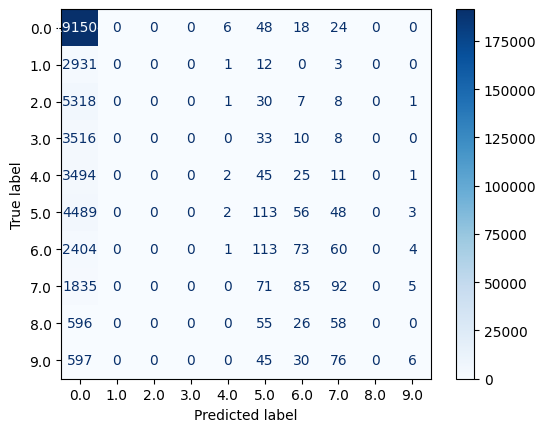

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

accuracy = model.score(x_test, y_test)
print(accuracy)


y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

# 오분류표 히트맵
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
disp.plot(cmap='Blues')

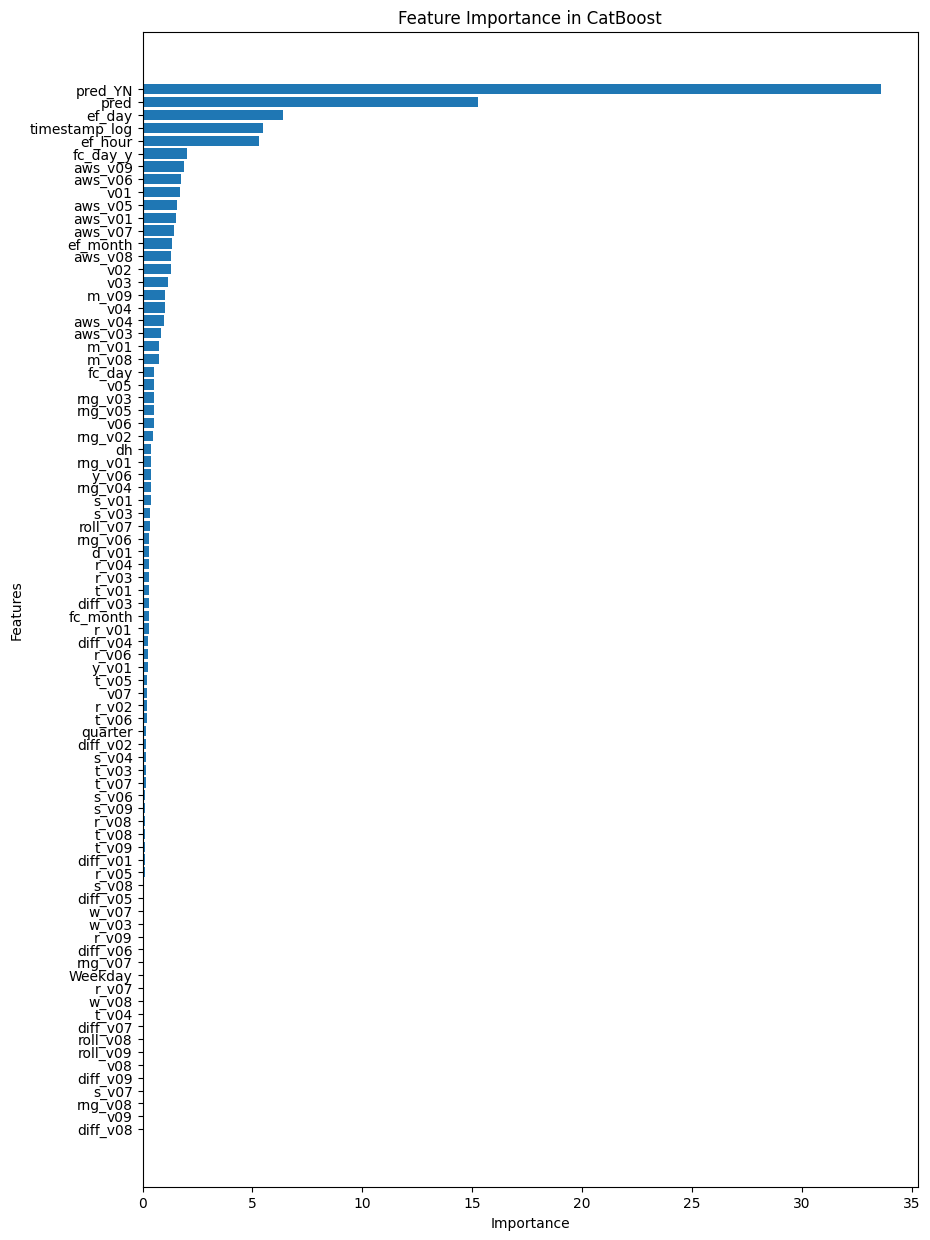

82 -->  82


In [61]:
# 변수 중요도 확인
feature_importance = model.feature_importances_

# 변수의 중요도와 변수명을 묶어서 리스트로 생성
lis = list(zip(feature_importance, x_train.columns))

# 중요도를 기준으로 내림차순 정렬
lis_srt = sorted(lis, key=lambda x: x[0], reverse=False)

# 중요도와 변수명 추출
importance_srt = [x[0] for x in lis_srt]
feature_names_srt = [x[1] for x in lis_srt]

# 가로 막대그래프 그리기
plt.figure(figsize=(10, 15))
plt.barh(feature_names_srt, importance_srt)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance in CatBoost')
plt.show()

result = []
for val, key in lis_srt:
    if val > 0:
        result.append(key)
        
print(len(lis_srt), '--> ', len(result))

----

In [92]:
joblib.dump(lis_srt, './data/lis_srt.pkl')
lis_srt = joblib.load('./data/lis_srt.pkl')

In [84]:
col2 = [x[1] for x in lis_srt if x[0]>=0.5]

x = temp.drop(columns=[target])
x = temp.loc[:, col2]

y = temp.loc[:, target]

# 데이터 분할
aa, bb = idx_find(temp)

x_train = x.iloc[:aa+1]
y_train = y.iloc[:aa+1]

x_val = x.iloc[aa+1:bb+1]
y_val = y.iloc[aa+1:bb+1]

x_test = x.iloc[bb+1:]
y_test = y.iloc[bb+1:]

In [85]:
# CatBoost 모델 학습
model = CatBoostClassifier(iterations=200, learning_rate=0.05, depth=10, verbose=0, random_state=42)
train_pool = Pool(x_train, y_train)
eval_pool = Pool(x_test, y_test)

# 모델 학습 및 학습 과정 기록
model.fit(train_pool, eval_set=eval_pool, plot=True)
print(model.get_best_score())

# 학습곡선 출력
plt.show()


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'learn': {'MultiClass': 0.3617106295379483}, 'validation': {'MultiClass': 0.35961957120901994}}


0.8965504587155964
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.97    191600
         1.0       0.00      0.00      0.00      2947
         2.0       0.33      0.06      0.10      5365
         3.0       0.33      0.13      0.19      3567
         4.0       0.21      0.16      0.18      3578
         5.0       0.29      0.25      0.27      4711
         6.0       0.39      0.28      0.32      2655
         7.0       0.41      0.22      0.29      2088
         8.0       0.39      0.14      0.20       735
         9.0       0.46      0.14      0.22       754

    accuracy                           0.90    218000
   macro avg       0.37      0.24      0.27    218000
weighted avg       0.85      0.90      0.87    218000



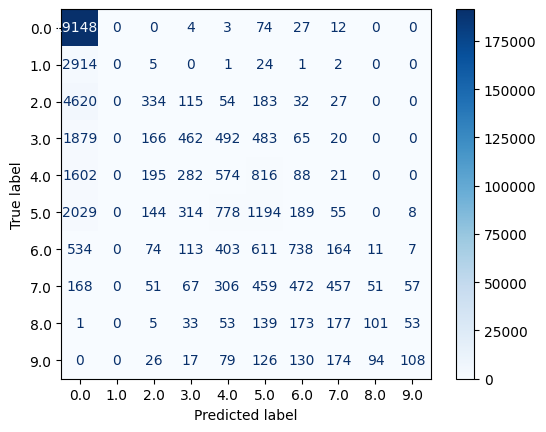

In [87]:
accuracy = model.score(x_test, y_test)
print(accuracy)

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

# 오분류표 히트맵
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
disp.plot(cmap='Blues')

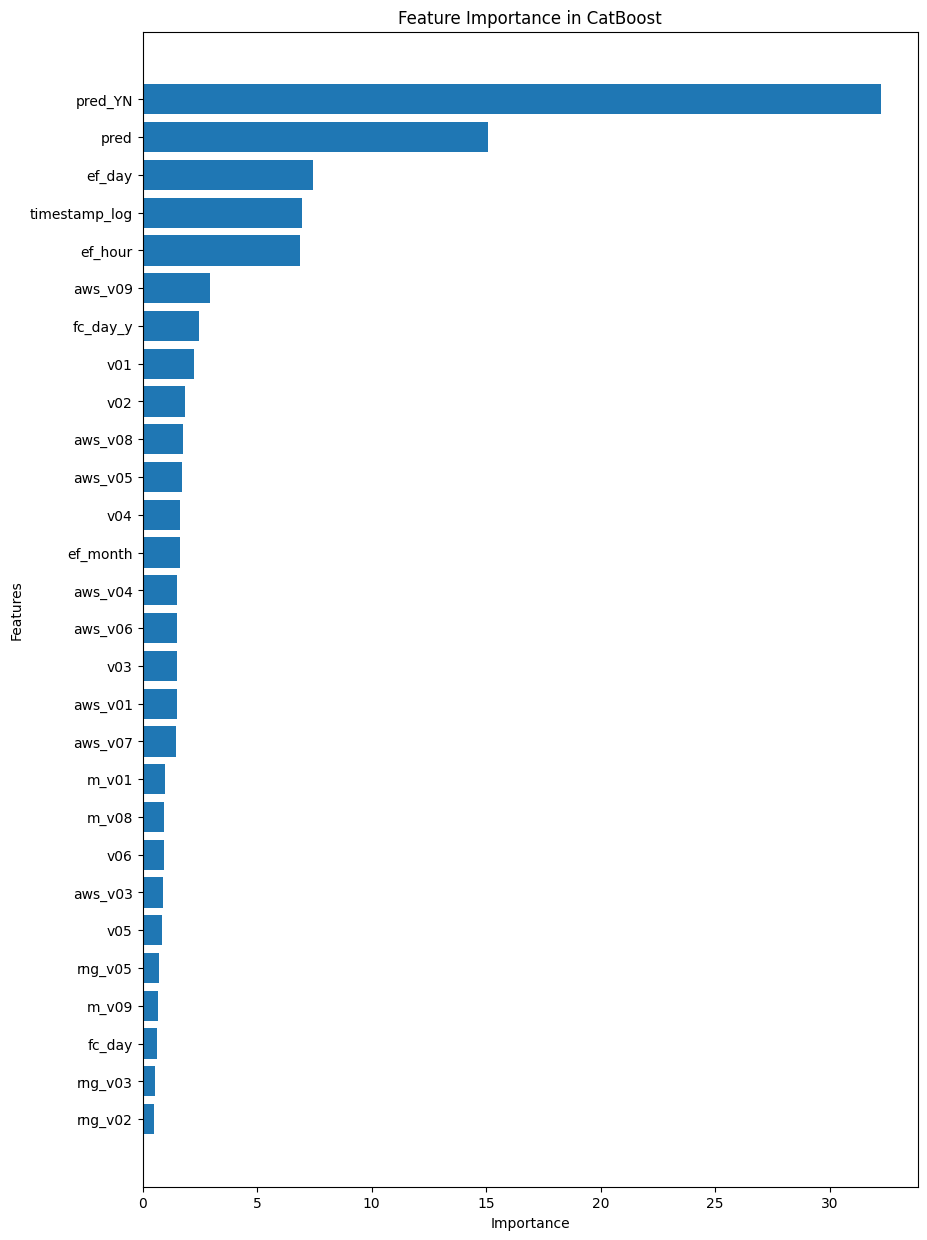

28 -->  28


In [83]:
# 변수 중요도 확인
feature_importance = model.feature_importances_

# 변수의 중요도와 변수명을 묶어서 리스트로 생성
lis = list(zip(feature_importance, x_train.columns))

# 중요도를 기준으로 내림차순 정렬
lis_srt = sorted(lis, key=lambda x: x[0], reverse=False)

# 중요도와 변수명 추출
importance_srt = [x[0] for x in lis_srt]
feature_names_srt = [x[1] for x in lis_srt]

# 가로 막대그래프 그리기
plt.figure(figsize=(10, 15))
plt.barh(feature_names_srt, importance_srt)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance in CatBoost')
plt.show()

result = []
for val, key in lis_srt:
    if val > 0:
        result.append(key)
        
print(len(lis_srt), '--> ', len(result))

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {"iterations": [100,200,300],
          'learning_rate':[0.1,0.01,0.001],
          'depth':[5,10,20]}

# 모델생성
dt = CatBoostClassifier(random_state=42)

# AutoML모델 생성
gs = GridSearchCV(dt, param_grid=params, n_jobs=-1, cv=5)

# AutoML모델 훈련
gs.fit(x_train, y_train)

# 찾은 최적모델 사용
dt = gs.best_estimator_
dt.get_best_score()

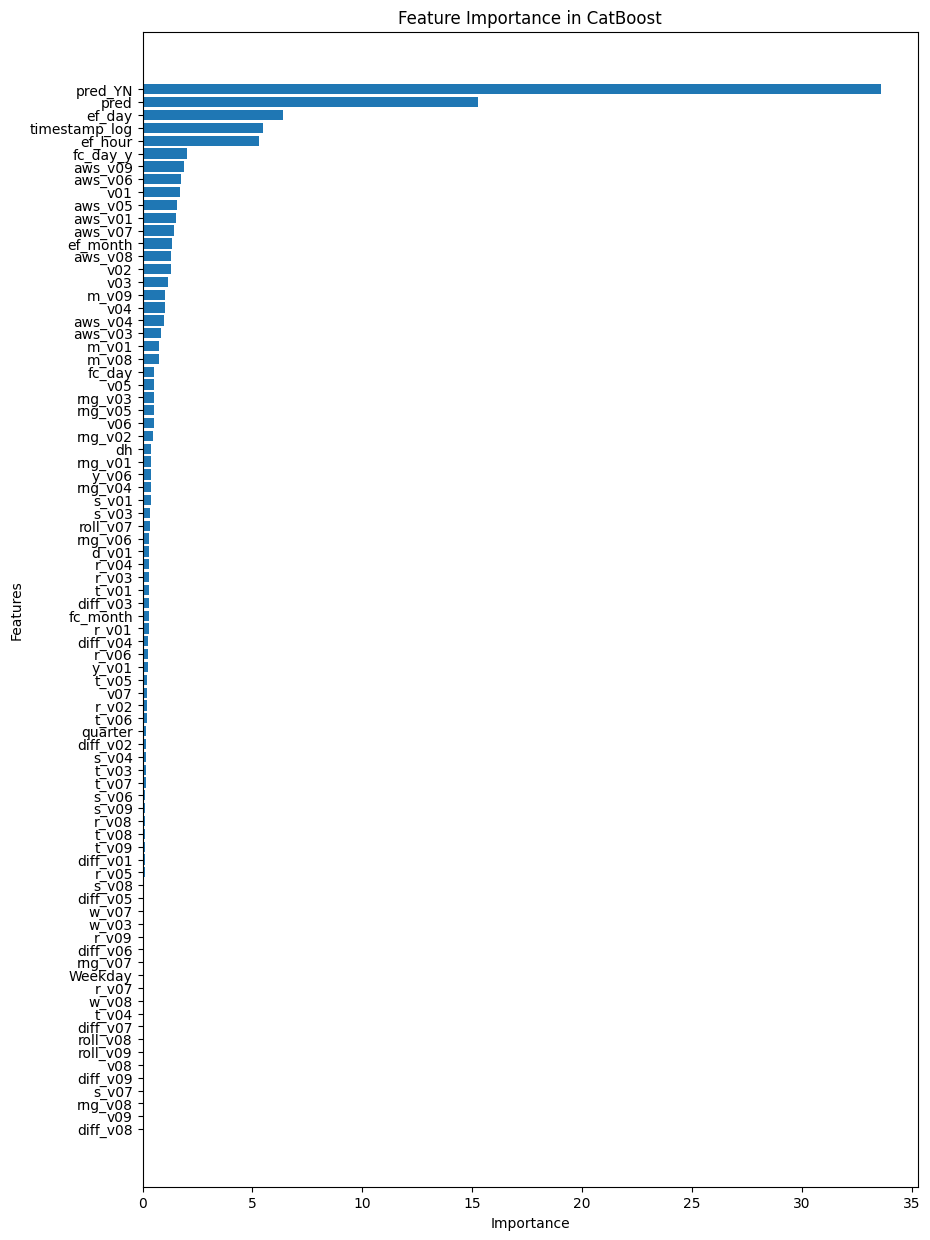

In [56]:
# 변수 중요도 확인
feature_importance = model.feature_importances_

# 변수의 중요도와 변수명을 묶어서 리스트로 생성
lis = list(zip(feature_importance, x_train.columns))

# 중요도를 기준으로 내림차순 정렬
lis_srt = sorted(lis, key=lambda x: x[0], reverse=False)

# 중요도와 변수명 추출
importance_srt = [x[0] for x in lis_srt]
feature_names_srt = [x[1] for x in lis_srt]

# 가로 막대그래프 그리기
plt.figure(figsize=(10, 15))
plt.barh(feature_names_srt, importance_srt)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance in CatBoost')
plt.show()


In [ ]:
# 변수 중요도 확인
feature_importance = model2.feature_importances_

# 변수의 중요도와 변수명을 묶어서 리스트로 생성
lis = list(zip(feature_importance, x_train.columns))

# 중요도를 기준으로 내림차순 정렬
lis_srt = sorted(lis, key=lambda x: x[0], reverse=False)

# 중요도와 변수명 추출
importance_srt = [x[0] for x in lis_srt]
feature_names_srt = [x[1] for x in lis_srt]

# 가로 막대그래프 그리기
plt.figure(figsize=(10, 15))
plt.barh(feature_names_srt, importance_srt)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance in CatBoost')
plt.show()


In [ ]:
print(len(lis_srt))
result = []
for val, key in lis_srt:
    if val > 0:
        result.append(key)
        
len(result)

In [22]:
# temp = temp2.loc[:, result + ['class_interval']]
# temp
temp.to_csv('./data/rainfall_train_v4_eda2.csv', index=False)

In [21]:
a = temp.isnull().sum().to_dict()

for val, i in a.items():
    if i>0:
        print(val)